# Module 2 Graded Quiz

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import edhec_risk_kit_206 as erk

1 Load the 30 Value Weighted industry portfolio returns. Limit the analysis to returns of the 30 VW portfolios from 1997 onwards (1997 included, 1996 not included, 2018 included). Also load the Market Caps of each of the 30 industries. Run a backtest of comparing a CapWeighted vs an EW portfolio over the period. Though these two weighting schemes do not need any estimation, use an estimation period of 36 months so that we can compare it in the next few questions. 

Hint: If you want to use the supplied code, import the final version of the backtester in file edhec_risk_kit_206 using:

import edhec_risk_kit_206 as erk

Remember that to load the  Value Weighted series you should use  erk.get_ind_returns(weighting="vw", ...)

and then use erk.backtest_ws(rets, estimation_window=36, weighting=...) The first month for which you have backtested returns should be 2000-01 and the last month should be 2018-12

What was the annualized return over period for the Cap Weighted Industry Portfolio?

In [14]:
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=30)["1997":"2018"]
ind_mcap = erk.get_ind_market_caps(30, weights=True)["1997":"2018"]

<AxesSubplot:title={'center':'30 Industries - CapWeighted vs Equally Weighted'}>

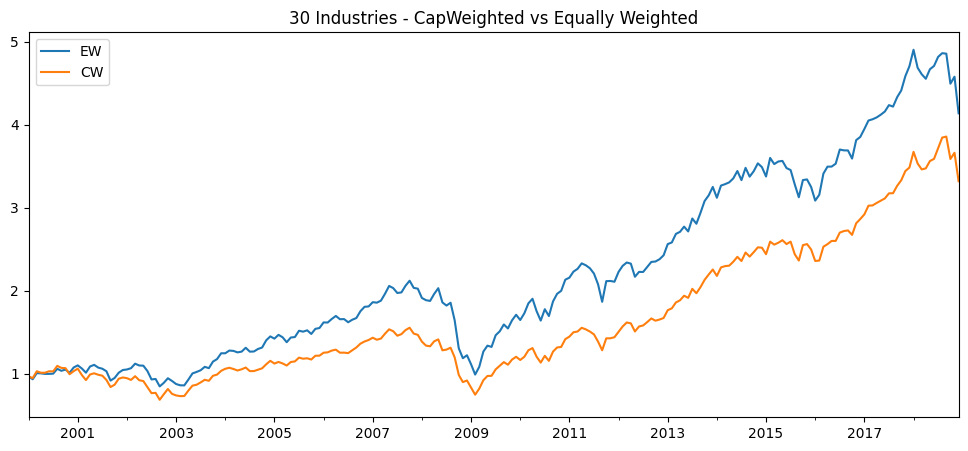

In [40]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36)
cwr = erk.backtest_ws(ind_rets, weighting=weight_cw, cap_weights=ind_mcap, estimation_window=36)
backtest_df = pd.DataFrame({"EW": ewr, "CW": cwr})
backtest_df.dropna(inplace = True)
(1+backtest_df).cumprod().plot(figsize=(12,5), title="30 Industries - CapWeighted vs Equally Weighted")

In [41]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

In [43]:
round(annualize_rets(cwr.dropna(), periods_per_year=12)*100,2)

6.52

2 Use the same data and period as the previous question.

What was the annualized volatility over the period for the Cap Weighted Industry Portfolio?

In [44]:
def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    """
    return r.std()*(periods_per_year**0.5)

In [45]:
round(annualize_vol(cwr.dropna(), periods_per_year=12)*100,2)

15.15

3 Use the same data and period as the previous question.

What was the annualized return over period for the Equal Weighted Industry Portfolio?

In [22]:
round(annualize_rets(ewr.dropna(), periods_per_year=12)*100,2)

7.76

4 Use the same data and period as the previous question.

What was the annualized volatility over the period for the Equal Weighted Industry Portfolio? 

In [46]:
round(annualize_vol(ewr.dropna(), periods_per_year=12)*100,2)

15.87

5 Now using the same data and same period, re-run the EW backtest but this time create a tethered EW portfolio by removing Microcap industries using a threshold of 1% and a max cap-weight multiple of 2X

What was the annualized return over the period for the tethered Equal Weighted Industry Portfolio?

In [47]:
ewtr = erk.backtest_ws(ind_rets, estimation_window=36, cap_weights=ind_mcap, max_cw_mult=2, microcap_threshold=.01)
round(annualize_rets(ewtr.dropna(), periods_per_year=12)*100,2)

7.68

6 Use the same tethered EW portfolio (by removing Microcap industries using a threshold of 1% and a max cap-weight multiple of 2X) as in the previous question.

What was the annualized volatility over the period for the tethered Equal Weighted Industry Portfolio? 

In [48]:
round(annualize_vol(ewtr.dropna(), periods_per_year=12)*100,2)

14.08

Question 7
What was Tracking Error between the Pure EW (without any tethering) portfolio and the CW portfolio?

In [49]:
def tracking_error(r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    return np.sqrt(((r_a - r_b)**2).sum())

In [50]:
(tracking_error(ewr.dropna(), cwr.dropna())*100).round(2)

18.75

8 Now consider the Tethered EW portfolio you previously created (by removing Microcap industries using a threshold of 1% and a max cap-weight multiple of 2X)

What was Tracking Error between the Tethered EW portfolio and the CW portfolio?

In [51]:
(tracking_error(ewtr.dropna(), cwr.dropna())*100).round(2)

11.67

9 Run a backtest for the same period (1997 onwards i.e. 1997 included, 1996 not included, 2018 included), using an estimation window of 36 months as above, to build the Global Minimum Variance Portfolio by estimating the Covariance matrix using Sample Covariance. (This might take a minute or so to run depending on your computer power!) 

What was the annualized return over the period for the GMV Portfolio?

In [53]:
def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return gmv(est_cov)

def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

from scipy.optimize import minimize
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol 

In [55]:
gmv_port = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
gmv_port.dropna(inplace = True)

In [56]:
round(annualize_rets(gmv_port.dropna(), 12)*100,2)

6.63

Question 10
Use the same GMV portfolio as the previous question. What was the annualized volatility over the period for the GMV Portfolio?

In [57]:
round(annualize_vol(gmv_port.dropna(), 12)*100,2)

11.74

11 Run a backtest for the same period as the previous question, and again using an estimation window of 36 months as above, to build the Global Minimum Variance Portfolio but this time, estimating the Covariance matrix using Shrinkage between the Constant Correlation and Sample Covariance estimates using a delta of 0.25. (This might take a minute or so to run depending on your computer power!)

What was the annualized return over the period for this new Shrinkage-GMV Portfolio?

In [58]:
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    return pd.DataFrame(ccor * np.outer(sd, sd), index=r.columns, columns=r.columns)

def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

In [59]:
gmv_port_shr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.25)

In [60]:
round(annualize_rets(gmv_port_shr.dropna(), 12)*100,2)

6.85

12 Using the same Shrinkage-GMV portfolio return series you used in the previous question, what was the annualized volatility over the period for the Shrinkage-GMV Portfolio?

In [61]:
round(annualize_vol(gmv_port_shr.dropna(), 12)*100,2)

11.46